<a href="https://colab.research.google.com/github/TheTalesman/ml-notebooks/blob/main/TALKV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1 - Coleta de dados


In [ ]:
import pandas as pd

ds_kanban=pd.read_csv('/content/demands-2021-05-03 19 08 33 -0300.csv')  #realiza a leitura do dataset

In [ ]:
ds_kanban.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 414 non-null    int64 
 1   portfolio_unit     144 non-null    object
 2   current_stage      414 non-null    object
 3   project_id         414 non-null    int64 
 4   external_id        414 non-null    object
 5   demand_title       414 non-null    object
 6   demand_type        414 non-null    object
 7   class_of_service   414 non-null    object
 8   demand_score       414 non-null    object
 9   effort_downstream  414 non-null    object
 10  effort_upstream    414 non-null    object
 11  created_date       414 non-null    object
 12  commitment_date    368 non-null    object
 13  end_date           414 non-null    object
dtypes: int64(2), object(12)
memory usage: 45.4+ KB


# Etapa 2 - Preparação dos dados

In [ ]:
#o que fazer com dados incompletos?
ds_kanban["portfolio_unit"].fillna('no-cat', inplace = True)

In [ ]:
ds_kanban.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 414 non-null    int64 
 1   portfolio_unit     414 non-null    object
 2   current_stage      414 non-null    object
 3   project_id         414 non-null    int64 
 4   external_id        414 non-null    object
 5   demand_title       414 non-null    object
 6   demand_type        414 non-null    object
 7   class_of_service   414 non-null    object
 8   demand_score       414 non-null    object
 9   effort_downstream  414 non-null    object
 10  effort_upstream    414 non-null    object
 11  created_date       414 non-null    object
 12  commitment_date    368 non-null    object
 13  end_date           414 non-null    object
dtypes: int64(2), object(12)
memory usage: 45.4+ KB


In [ ]:
#vamos separar em 2 data frames
df_complete = ds_kanban
df_trimmed = ds_kanban[ds_kanban['commitment_date'].notna()]
df_nocommit = ds_kanban.drop(columns = ["commitment_date"])

In [ ]:
df_complete.info()
df_trimmed.info()
df_nocommit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 414 non-null    int64 
 1   portfolio_unit     414 non-null    object
 2   current_stage      414 non-null    object
 3   project_id         414 non-null    int64 
 4   external_id        414 non-null    object
 5   demand_title       414 non-null    object
 6   demand_type        414 non-null    object
 7   class_of_service   414 non-null    object
 8   demand_score       414 non-null    object
 9   effort_downstream  414 non-null    object
 10  effort_upstream    414 non-null    object
 11  created_date       414 non-null    object
 12  commitment_date    368 non-null    object
 13  end_date           414 non-null    object
dtypes: int64(2), object(12)
memory usage: 45.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 368 entries, 0 to 412
Data columns (total

# Etapa 3 - Escolha do modelo
### Qual objetivo?
### Classificaçã binária, multiclasse ou regressão?


In [ ]:
# é possível prever o nosso esforço upstream/downstream a partir da classe de serviço?


In [ ]:
df_dummy=pd.get_dummies(df_complete,columns=["class_of_service","demand_type","portfolio_unit"])


In [ ]:

from sklearn import preprocessing

def transform(df,*columns):
  for column in columns:
    #troca , por .
    df[column] = df[column].apply(lambda x: x.replace(",", ".")) 
    #converte de string para float
    df[column] = pd.to_numeric(df[column],errors='raise')
    #normalize de -1 a 1 e retorna
    x = df[column].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x=x.reshape(-1, 1)
    x_scaled = min_max_scaler.fit_transform(x)
    df[column] = pd.DataFrame(x_scaled)
  return df

df_dummy = transform(df_dummy,'effort_upstream','effort_downstream','demand_score')

delta = (pd.to_datetime(df_dummy['end_date']) - pd.to_datetime(df_dummy['created_date']))
delta_commitment = (pd.to_datetime(df_dummy['end_date']) - pd.to_datetime(df_dummy['commitment_date']))
df_dummy["lead_time"] = pd.to_numeric(delta.dt.days, downcast='integer')
df_dummy["cycle_time"] = pd.to_numeric(delta_commitment.dt.days, downcast='integer')
df_dummy["cycle_time"]= df_dummy["cycle_time"].fillna(df_dummy["cycle_time"].mean())


In [ ]:
df_dummy

,id,current_stage,project_id,external_id,demand_title,demand_score,effort_downstream,effort_upstream,created_date,commitment_date,end_date,class_of_service_expedite,class_of_service_fixed_date,class_of_service_intangible,class_of_service_standard,demand_type_bug,demand_type_chore,demand_type_feature,portfolio_unit_Ads,portfolio_unit_Ambientes,portfolio_unit_Analise de indicadores,portfolio_unit_Aumentar o Hit-ratio,portfolio_unit_Capas,portfolio_unit_Chatbot,portfolio_unit_Design,portfolio_unit_Diminuicao de trafego,portfolio_unit_Divulgação,portfolio_unit_Florida,portfolio_unit_Gerenciamento de prêmios,portfolio_unit_Integração GigiGo,portfolio_unit_Matérias e colunas,portfolio_unit_Migração,portfolio_unit_Multiplos estados,portfolio_unit_New Content,portfolio_unit_Nova experiência,portfolio_unit_Novo Front,portfolio_unit_OCR notas fiscais,portfolio_unit_Paywall Dinâmico,portfolio_unit_Perfil,portfolio_unit_Performance e Segurança,portfolio_unit_Pre-paid virtual card,portfolio_unit_Produtos e Marcas,portfolio_unit_Programáticas,portfolio_unit_Scan,portfolio_unit_Segurança,"portfolio_unit_Segurança, performance e Analytics",portfolio_unit_Serviços,portfolio_unit_SignIn,portfolio_unit_User Experience,portfolio_unit_Usuário,portfolio_unit_no-cat,portfolio_unit_Área comum,lead_time,cycle_time
0,17711,Arquivado,639,EBANX-2,Permitir que o cliente tenha acesso as informa...,0.000000,0.092423,0.078125,2021-03-10T16:23:14-03:00,2021-04-12T14:19:17-03:00,2021-04-30T14:36:17-03:00,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,50,18.000000
1,17731,Done,641,NSCT-480,Verificar comportamento incorreto AMP,0.000000,0.285077,0.000000,2021-03-12T11:08:14-03:00,2021-03-26T10:58:51-03:00,2021-04-29T10:39:27-03:00,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,47,33.000000
2,18241,Done,637,ISTOE-17,[ISTOÉ Dinheiro] Criar elementos mínimos para ...,0.000000,0.203923,0.093750,2021-04-09T11:39:58-03:00,2021-04-13T14:23:56-03:00,2021-04-28T12:08:55-03:00,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,19,14.000000
3,17795,Done,562,SF-25,Allow the user to view global location page,0.000000,0.067308,0.013021,2021-03-16T18:09:25-03:00,2021-04-13T14:54:09-03:00,2021-04-23T19:05:30-03:00,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,38,10.000000
4,17619,Done,562,SF-22,Allow end user to see Our people page,0.000000,0.201615,0.013021,2021-03-04T11:29:08-03:00,2021-04-12T20:12:48-03:00,2021-04-23T11:48:47-03:00,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,50,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,8398,Arquivado,316,LN-59,Ajustes do SCAN Nestlé,0.873563,0.162462,0.000000,2020-01-06T00:00:00-03:00,2020-01-06T00:00:00-03:00,2020-01-10T00:00:00-03:00,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,4.000000
410,8583,Arquivado,315,NSCT-296,Desligamento da Cloudflare,0.000000,0.218462,0.251302,2020-01-07T00:00:00-03:00,NaN,2020-01-10T00:00:00-03:00,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,8.861413
411,8400,Arquivado,315,NSCT-293,Redirecionamento e indexação site Itapema,0.000000,0.075692,0.000000,2020-01-06T00:00:00-03:00,2020-01-06T00:00:00-03:00,2020-01-07T00:00:00-03:00,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1.000000
412,8397,Arquivado,316,LN-58,Permitir que o token da commarket seja renovad...,0.655172,0.000000,0.000000,2020-01-06T00:00:00-03:00,2020-01-06T00:00:00-03:00,2020-01-07T00:00:00-03:00,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1.000000


In [ ]:
df_dummy.corr()

,id,project_id,demand_score,effort_downstream,effort_upstream,class_of_service_expedite,class_of_service_fixed_date,class_of_service_intangible,class_of_service_standard,demand_type_bug,demand_type_chore,demand_type_feature,portfolio_unit_Ads,portfolio_unit_Ambientes,portfolio_unit_Analise de indicadores,portfolio_unit_Aumentar o Hit-ratio,portfolio_unit_Capas,portfolio_unit_Chatbot,portfolio_unit_Design,portfolio_unit_Diminuicao de trafego,portfolio_unit_Divulgação,portfolio_unit_Florida,portfolio_unit_Gerenciamento de prêmios,portfolio_unit_Integração GigiGo,portfolio_unit_Matérias e colunas,portfolio_unit_Migração,portfolio_unit_Multiplos estados,portfolio_unit_New Content,portfolio_unit_Nova experiência,portfolio_unit_Novo Front,portfolio_unit_OCR notas fiscais,portfolio_unit_Paywall Dinâmico,portfolio_unit_Perfil,portfolio_unit_Performance e Segurança,portfolio_unit_Pre-paid virtual card,portfolio_unit_Produtos e Marcas,portfolio_unit_Programáticas,portfolio_unit_Scan,portfolio_unit_Segurança,"portfolio_unit_Segurança, performance e Analytics",portfolio_unit_Serviços,portfolio_unit_SignIn,portfolio_unit_User Experience,portfolio_unit_Usuário,portfolio_unit_no-cat,portfolio_unit_Área comum,lead_time,cycle_time
id,1.000000,0.930417,-0.372991,-0.042031,0.077617,0.054540,0.111640,0.215534,-0.236590,0.029303,0.037318,-0.051793,9.058975e-02,0.109630,0.000792,0.000879,0.063395,-0.054677,9.038005e-02,-0.002488,-0.223359,-0.055278,0.160280,0.094668,0.113753,0.095956,-0.059759,-0.100755,0.074048,1.870552e-01,-0.073521,0.140311,-0.089778,0.115310,0.066619,-0.071256,0.118777,0.077537,-0.185919,0.124502,0.054683,-0.084932,0.046285,0.177915,-0.187200,-0.222815,0.052460,-2.849106e-02
project_id,0.930417,1.000000,-0.345673,0.005706,0.115313,-0.025926,0.100006,0.255792,-0.198365,-0.006248,0.105059,-0.092387,1.130343e-01,0.110035,0.017518,0.017518,0.081763,0.044548,6.242163e-02,0.030416,-0.240522,-0.045905,0.163793,0.102315,0.144730,0.113034,-0.059408,-0.080057,0.078796,2.277329e-01,-0.075226,0.122138,-0.075226,0.105946,0.080797,-0.075226,0.106265,0.075645,-0.169032,0.110035,0.043119,-0.056825,0.037323,0.150979,-0.249236,-0.200492,0.143011,4.658466e-02
demand_score,-0.372991,-0.345673,1.000000,-0.028329,-0.105810,-0.016227,-0.086045,-0.099890,0.122247,0.068579,-0.061396,0.014906,-2.364808e-02,-0.041160,-0.016701,-0.016701,-0.016701,-0.058642,-2.364808e-02,-0.028998,0.567504,-0.028998,-0.056076,-0.037528,-0.033525,-0.023648,-0.037528,-0.016701,-0.033525,-4.764435e-02,0.204502,-0.041160,0.132482,-0.033525,-0.016701,0.189069,-0.041160,-0.033525,0.309243,-0.041160,-0.016701,-0.041160,-0.016701,-0.061112,-0.216312,0.417724,-0.148495,-8.367740e-02
effort_downstream,-0.042031,0.005706,-0.028329,1.000000,0.121600,-0.186216,0.087736,-0.009750,0.089770,-0.094122,0.023829,0.034852,-5.932286e-02,-0.037956,-0.001583,0.035506,0.173112,-0.049909,-5.932286e-02,0.012185,-0.080336,0.041116,0.004459,0.013489,0.065270,0.085737,-0.036891,-0.022546,-0.056586,-1.195192e-01,-0.030609,0.012162,0.058082,0.053301,-0.001532,-0.019321,-0.003459,-0.008572,-0.032543,-0.020483,0.020993,-0.013173,0.005136,-0.019192,0.087206,-0.048424,0.264467,4.575112e-01
effort_upstream,0.077617,0.115313,-0.105810,0.121600,1.000000,-0.202172,0.010355,0.220342,-0.001083,-0.101020,0.106846,-0.036971,6.897347e-03,-0.007191,0.043977,-0.032327,0.015363,-0.061875,6.226793e-02,-0.025767,-0.101833,0.010114,-0.056135,-0.046919,-0.028992,-0.029566,0.068811,-0.032327,0.071522,4.342736e-01,-0.032327,0.030418,-0.032327,0.006906,-0.003713,-0.032327,0.071161,-0.036171,-0.072637,-0.062038,0.039208,-0.036574,-0.022789,-0.065936,-0.001518,-0.037132,0.190096,1.790731e-01
class_of_service_expedite,0.054540,-0.025926,-0.016227,-0.186216,-0.202172,1.000000,-0.086306,-0.100194,-0.599320,0.309639,-0.014639,-0.172998,-2.371994e-02,-0.041285,-0.016752,-0.016752,-0.016752,-0.058820,-2.371994e-02,-0.029086,-0.053562,-0.029086,0.042214,-0.037642,-0.033627,-0.023720,-0.037642,-0.016752,-0.033627,-4.778914e-02,0.14453

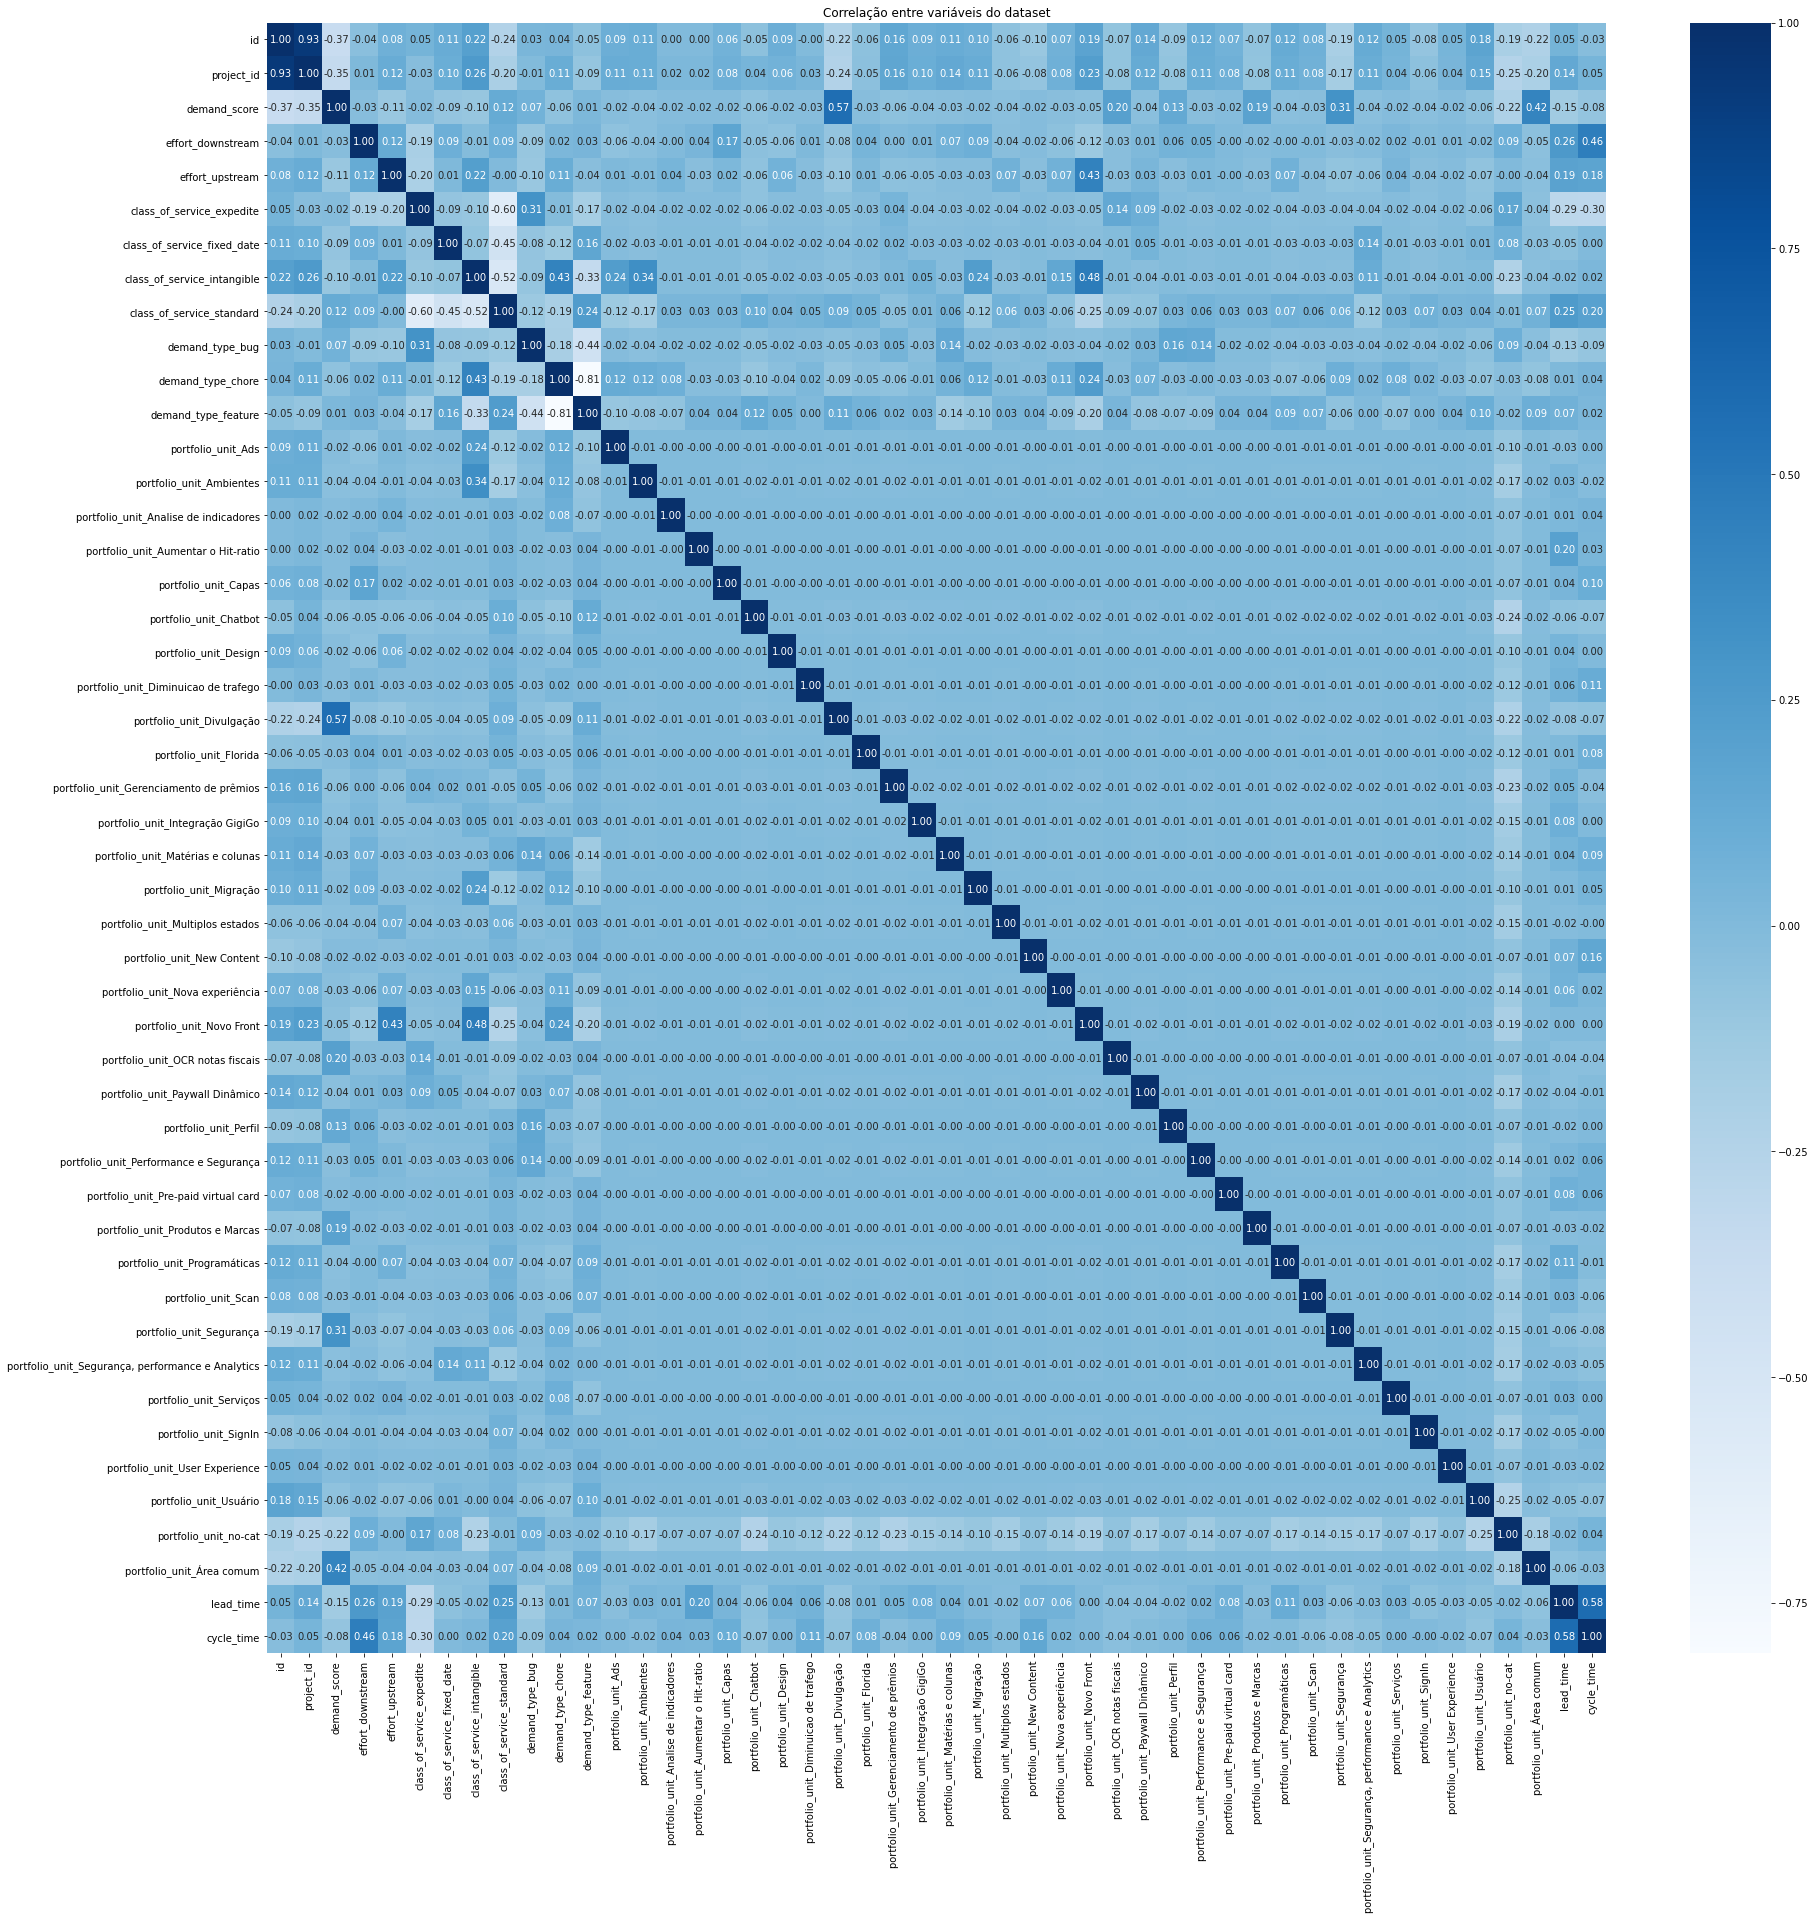

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(30, 30))
sns.heatmap(df_dummy.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.title('Correlação entre variáveis do dataset')
plt.show()

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns# Carregando dataset
data = df_dummy.drop(columns=["current_stage", "external_id","demand_title","end_date","created_date","commitment_date"])

X = data
y = data.lead_time# Criando conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)# Treinando modelo
model  = RandomForestClassifier()
model.fit(X_train, y_train)# Mostrando importância de cada feature
model.feature_importances_


array([0.12291827, 0.08521539, 0.02651853, 0.11126487, 0.09423961,
       0.01144378, 0.00796927, 0.00701259, 0.01590262, 0.01128769,
       0.0184875 , 0.02161886, 0.00064828, 0.00380483, 0.00162389,
       0.00199816, 0.00157082, 0.006992  , 0.0019363 , 0.00319778,
       0.00362175, 0.00363918, 0.0068872 , 0.00466314, 0.00221859,
       0.        , 0.00273151, 0.        , 0.00460451, 0.00234713,
       0.00132868, 0.0024111 , 0.00090725, 0.00220204, 0.        ,
       0.00052625, 0.00262565, 0.00172476, 0.00355278, 0.00248737,
       0.0014594 , 0.00364922, 0.00111311, 0.00538532, 0.02219305,
       0.0037462 , 0.21509374, 0.14323001])

Text(0.5, 1.0, 'Importância de cada feature')

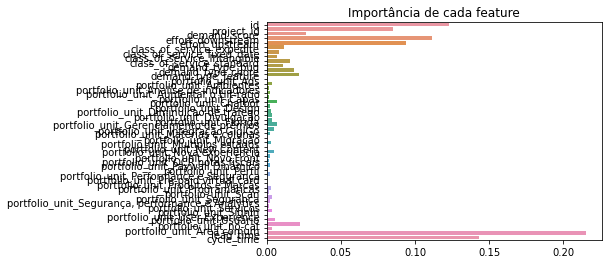

In [ ]:
importances = pd.Series(data=model.feature_importances_, index=list(X.columns))
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada feature')

In [ ]:
#regressão utilizando o otimizador
#Definindo as bibliotecas
import numpy as np  #biblioteca necessária para trabalhar com os vetores e matrizes
import scipy   #biblioteca necessária para obter as funções de treinamento 
import matplotlib.pyplot as plt #biblioteca utilizada para construir os gráficos
from scipy.optimize import curve_fit # biblioteca necessária para realiza a otimização dos MSE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
A1_dis = KBinsDiscretizer(n_bins=2, encode='ordinal',
                           strategy = "kmeans").fit_transform(df_dummy[['lead_time']])
df_dummy["lead_time"] = A1_dis
from sklearn.preprocessing import KBinsDiscretizer
A1_dis = KBinsDiscretizer(n_bins=2, encode='ordinal',
                           strategy = "kmeans").fit_transform(df_dummy[['cycle_time']])
df_dummy["cycle_time"] = A1_dis

In [ ]:
xData = np.array(df_dummy["portfolio_unit_Divulgação"])    #transformando a lista em array
yData = np.array(df_dummy["demand_score"]) #transformando a lista em array

In [ ]:
reg= LinearRegression()
x_Reshaped=xData.reshape((-1, 1)) #coloca os dados no formato 2D
regressao= reg.fit (x_Reshaped,yData) # encontra os coeficientes (realiza a regressão)


In [ ]:
previsao=reg.predict(x_Reshaped)
#parâmetros encontrados
print('Y = {}X {}'.format(reg.coef_,reg.intercept_))
from sklearn.metrics import r2_score #método para o cálculo do R2

R_2 = r2_score(yData, previsao)  #realiza o cálculo do R2

print("Coeficiente de Determinação (R2):", R_2)



Y = [0.81281438]X 0.05500170706725845
Coeficiente de Determinação (R2): 0.3220611971961699


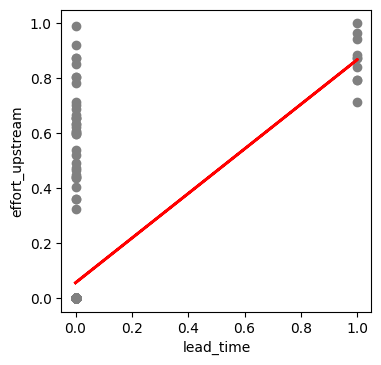

In [ ]:
plt.figure(figsize=(4, 4), dpi=100)
plt.scatter(xData, yData,  color='gray') #realiza o plot do gráfico de dispersão
plt.plot(xData, previsao, color='red', linewidth=2, ) # realiza o plto da "linha"
plt.xlabel("lead_time")
plt.ylabel("effort_upstream")
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


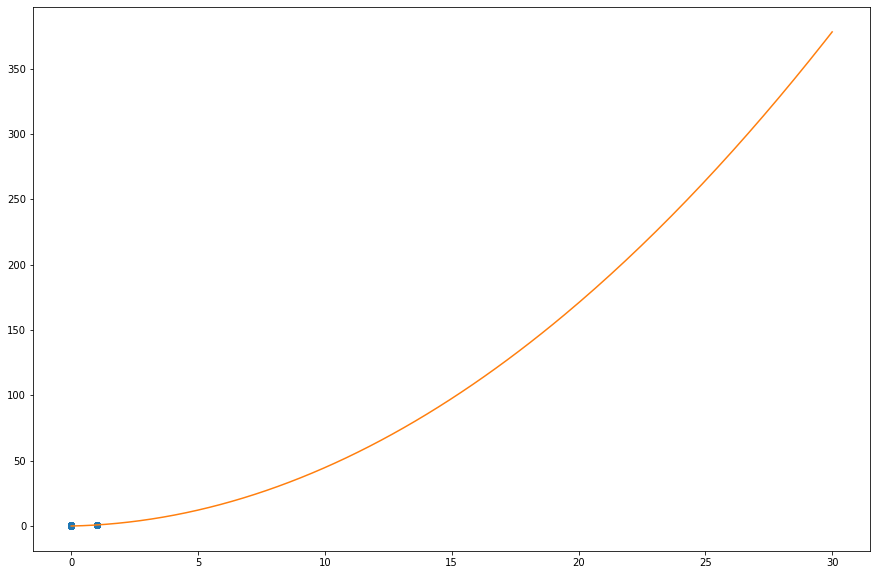

In [ ]:
alto_grau = np.poly1d(np.polyfit(xData, yData,  2))

t = np.linspace(0, 30, 200)
plt.figure(figsize=(15,10))
plt.plot(xData, yData, 'o', t, alto_grau(t), '-')

In [ ]:
from sklearn.metrics import r2_score #método para o cálculo do R2 (coeficiente de determinação)
R_2 = r2_score(yData, alto_grau(xData))  #realiza o cálculo do R2

print("Coeficiente de Determinação (R2):", R_2)

Coeficiente de Determinação (R2): 0.32206119719616966


In [ ]:
#X = df_dummy.drop(columns=["lead_time","current_stage", "external_id","demand_title","end_date","created_date","commitment_date"])
X = df_dummy[["demand_type_chore","demand_type_bug","demand_type_feature","class_of_service_fixed_date","class_of_service_expedite","class_of_service_standard","class_of_service_fixed_date", "class_of_service_intangible", "effort_upstream"]]
y = df_dummy["cycle_time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)# divide 20% para teste
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  #objeto que normaliza os dados
scaler.fit(X_train)  #realiza a normalização dos dados

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf = RandomForestClassifier(max_depth=10, random_state=1)

# Realiza o treinamento do classificador
clf = clf.fit(X_train,y_train)

#Realiza a previsão de classificaçao 
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        72
         1.0       0.00      0.00      0.00        11

    accuracy                           0.82        83
   macro avg       0.43      0.47      0.45        83
weighted avg       0.75      0.82      0.78        83



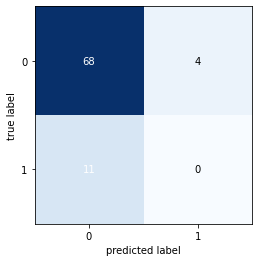

In [ ]:
matriz_confusao = confusion_matrix(y_test, y_pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=matriz_confusao)
plt.show()